## Chapter3_Introduction_Keras_and_TensorFlow

### Tensors

Tensors initialized with 0 and 1

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

y = tf.zeros(shape=(2, 1))
print(y)


tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


Tensors initialized with random distributions

Normal distribution
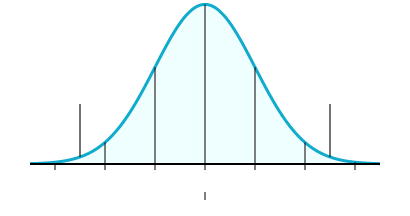

In [2]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-0.7910174 ]
 [-1.2220672 ]
 [ 0.45723647]], shape=(3, 1), dtype=float32)


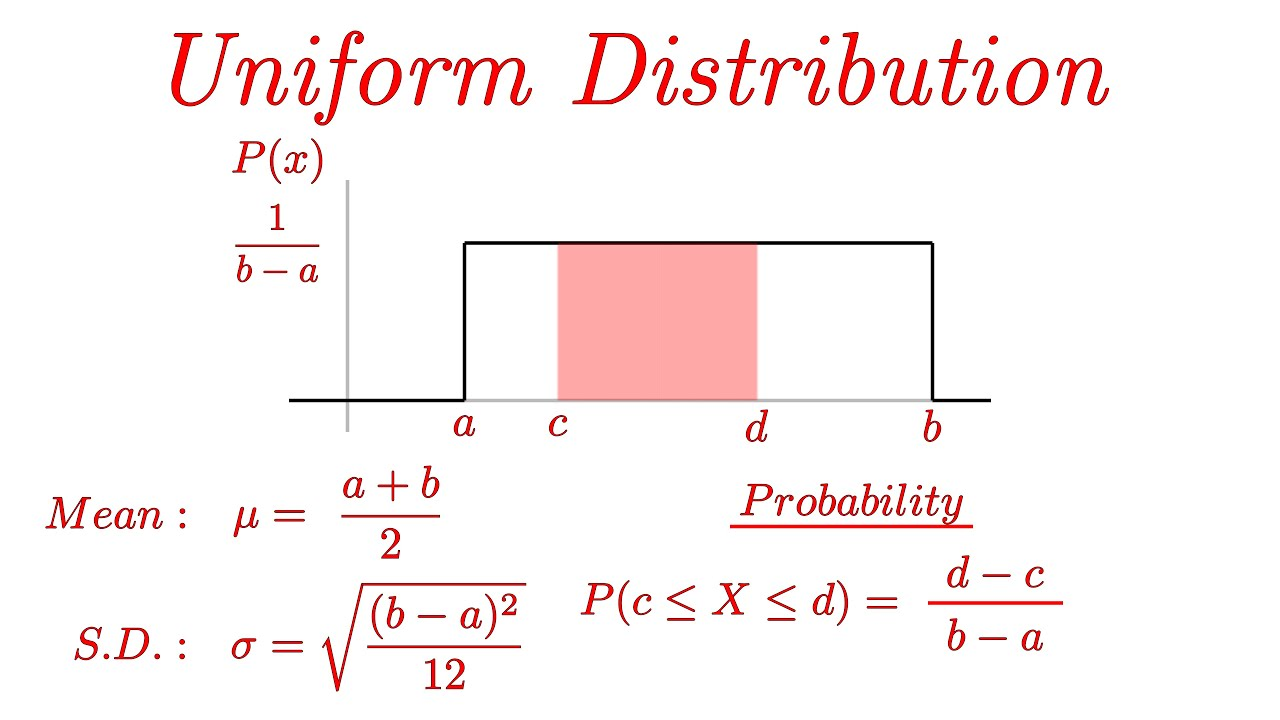

In [3]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.18102968]
 [0.04508197]
 [0.43846   ]], shape=(3, 1), dtype=float32)


**A significant difference between NumPy arrays and TensorFlow tensors is that TensorFlow tensors aren’t assignable: they’re constant.** 

==> this is why tf.Variable is needed


In [4]:
x = tf.ones(shape=(2, 2))
x[0, 0] = 0.

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [ ]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

v[0, 0].assign(3.)

assign_add() and assign_sub() are efficient equivalents of += and -=

In [ ]:
v.assign_add(tf.ones((3, 1)))

In [ ]:
a = tf.ones((2, 2))
print(f"a: {a}\n")
b = tf.square(a)
print(f"b: {b}\n")
c = tf.sqrt(a)
print(f"c: {c}\n")
d = b + c
print(f"d: {d}\n")
e = tf.matmul(a, b)
print(f"e: {e}\n")
e *= d

Gradients are automatically computed only for the tf.Variables. With a constant tensor, you’d have to manually mark it as being tracked by calling tape.watch()

In [ ]:
input_var = tf.Variable(initial_value=3.) 
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

In [ ]:
time = tf.Variable(0.) 
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2 
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)
print(speed)
print(acceleration)

 ### A linear classifier in pure TensorFlow

First generate some synthetic data

In [ ]:
import numpy as np

num_samples_per_class = 1000 
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In [ ]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

Generate the labels

In [ ]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [ ]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [ ]:
def model(inputs):
    y = tf.matmul(inputs, W) + b
    return y

In [ ]:
def loss(targets, pred):
    losses = tf.square(targets - pred)
    return tf.reduce_mean(losses)

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        lss = loss(targets, predictions)
    grad_loss_W, grad_loss_b = tape.gradient(lss, [W,b])
    W.assign_sub(grad_loss_W * learning_rate)
    b.assign_sub(grad_loss_b * learning_rate)
    return lss

In [ ]:
for step in range(40):
    los = training_step(inputs, targets)
    print(f"Loss at step {step}: {los}")

In [ ]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

In [ ]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

Understanding Keras

-> the build method allows for the instantiation of the weights (and this includes their shape) only at runtime. This is because it is complicated to always specify the input shape and the code can get messy if there are multiple possible inputs



In [ ]:
from tensorflow import keras
  
class SimpleDense(keras.layers.Layer):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation
  
    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")
  
    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

We don't want our models to be instantiated like this:

`model = NaiveSequential([

    NaiveDense(input_size=784, output_size=32, activation="relu"),
    
    NaiveDense(input_size=32, output_size=64, activation="relu"),
    
    NaiveDense(input_size=64, output_size=32, activation="relu"),
    
    NaiveDense(input_size=32, output_size=10, activation="softmax")
    
])`

but we want them like this:

`model = keras.Sequential([

    SimpleDense(32, activation="relu"),
    
    SimpleDense(64, activation="relu"),
    
    SimpleDense(32, activation="relu"),
    
    SimpleDense(10, activation="softmax")
    
])`

In [ ]:
from tensorflow import keras
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

The data (inputs and targets) to train on.
It will typically be passed either in the form of NumPy arrays or a TensorFlow Dataset object. You’ll learn more about the Dataset API in the next chapters.


The number of epochs to train for: how many times the training loop should iterate over the data passed.


The batch size to use within each epoch of mini-batch gradient descent: the number of training examples considered to compute the gradients for one weight update step.

In [ ]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

In [ ]:
history.history

To keep an eye on how the model does on new data, it’s standard practice to reserve a subset of the training data as validation data

In [ ]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])
  
indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]
 
num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)